In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# AvgTopK Pooling Layer
class AvgTopKPooling2D(nn.Module):
    def __init__(self, k=2, pool_size=2):
        super(AvgTopKPooling2D, self).__init__()
        self.k = k
        self.pool_size = pool_size

    def forward(self, x):
        # Unfold: [B, C*ks*ks, L]
        unfolded = F.unfold(x, kernel_size=self.pool_size, stride=self.pool_size)
        B, C_ks2, L = unfolded.shape
        C = x.shape[1]
        ks2 = self.pool_size * self.pool_size
        unfolded = unfolded.view(B, C, ks2, L)

        # Top-k avg
        topk_vals, _ = unfolded.topk(self.k, dim=2)
        avg_topk = topk_vals.mean(dim=2)

        H_out = W_out = int((x.shape[2] - self.pool_size) / self.pool_size + 1)
        return avg_topk.view(B, C, H_out, W_out)

# CNNAvgTopK based on your image
class CNNAvgTopK(nn.Module):
    def __init__(self, num_classes=100, k=2, pool_size=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = AvgTopKPooling2D(k=k, pool_size=pool_size)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = AvgTopKPooling2D(k=k, pool_size=pool_size)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


100%|██████████| 169M/169M [00:02<00:00, 59.3MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1: Train Acc = 15.83%, Val Acc = 25.85%
Epoch 2: Train Acc = 30.61%, Val Acc = 33.05%
Epoch 3: Train Acc = 38.92%, Val Acc = 36.52%
Epoch 4: Train Acc = 46.09%, Val Acc = 39.92%
Epoch 5: Train Acc = 52.59%, Val Acc = 40.38%
Epoch 6: Train Acc = 59.32%, Val Acc = 41.15%
Epoch 7: Train Acc = 66.53%, Val Acc = 40.32%
Epoch 8: Train Acc = 73.79%, Val Acc = 38.74%
Epoch 9: Train Acc = 80.02%, Val Acc = 39.22%
Epoch 10: Train Acc = 86.24%, Val Acc = 38.30%
Epoch 11: Train Acc = 90.17%, Val Acc = 38.04%
Epoch 12: Train Acc = 92.16%, Val Acc = 37.86%
Epoch 13: Train Acc = 93.54%, Val Acc = 37.60%
Epoch 14: Train Acc = 94.42%, Val Acc = 37.96%
Epoch 15: Train Acc = 94.96%, Val Acc = 37.88%
Epoch 16: Train Acc = 95.23%, Val Acc = 37.30%
Epoch 17: Train Acc = 95.97%, Val Acc = 36.73%
Epoch 18: Train Acc = 96.29%, Val Acc = 37.31%
Epoch 19: Train Acc = 96.60%, Val Acc = 37.05%
Epoch 20: Train Acc = 96.3

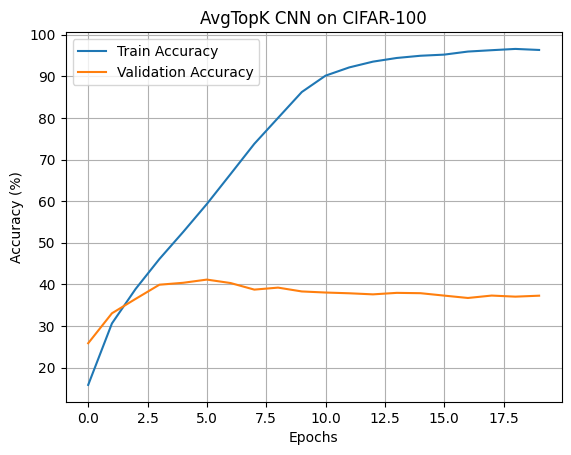

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# CIFAR-100 loaders
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# Model (as built above)
model = CNNAvgTopK(num_classes=100, k=3).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
train_acc, val_acc = [], []
for epoch in range(20):
    model.train()
    correct, total = 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_acc.append(train_accuracy)

    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    val_acc.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Acc = {train_accuracy:.2f}%, Val Acc = {val_accuracy:.2f}%")

# Plot
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("AvgTopK CNN on CIFAR-100")
plt.legend()
plt.grid()
plt.show()


Files already downloaded and verified
Files already downloaded and verified

=== Training with k=1, pool_size=2 ===
Epoch 1, Loss: 3.5650
Epoch 2, Loss: 2.6711
Epoch 3, Loss: 2.2113
Epoch 4, Loss: 1.8731
Epoch 5, Loss: 1.5599
Epoch 6, Loss: 1.2693
Epoch 7, Loss: 0.9803
Epoch 8, Loss: 0.6887
Epoch 9, Loss: 0.4764
Epoch 10, Loss: 0.3284
Epoch 11, Loss: 0.2401
Epoch 12, Loss: 0.1994
Epoch 13, Loss: 0.1635
Epoch 14, Loss: 0.1366
Epoch 15, Loss: 0.1570
Epoch 16, Loss: 0.1490
Epoch 17, Loss: 0.1237
Test Accuracy (k=1): 38.46%
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       100
           1       0.58      0.44      0.50       100
           2       0.23      0.25      0.24       100
           3       0.26      0.21      0.23       100
           4       0.33      0.21      0.26       100
           5       0.34      0.41      0.37       100
           6       0.44      0.38      0.41       100
           7       0.51      0.42      0.

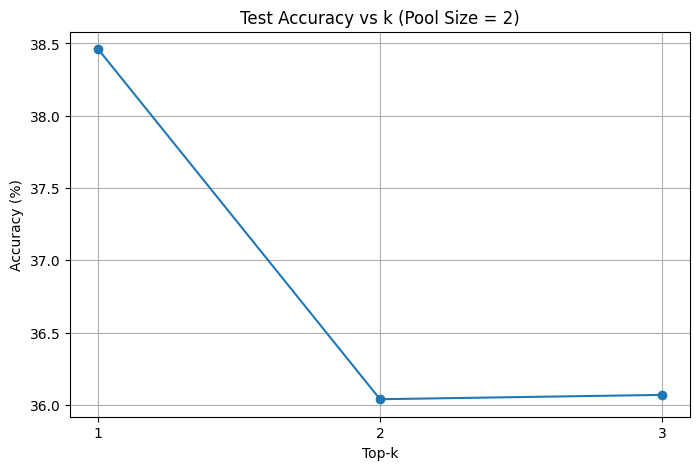

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom AvgTopK Pooling Layer
class AvgTopKPooling2D(nn.Module):
    def __init__(self, k, pool_size=2):
        super().__init__()
        self.k = k
        self.pool_size = pool_size

    def forward(self, x):
        unfolded = F.unfold(x, kernel_size=self.pool_size, stride=self.pool_size)
        B, C_k2, L = unfolded.shape
        C = C_k2 // (self.pool_size ** 2)
        patches = unfolded.view(B, C, self.pool_size ** 2, L)
        topk = torch.topk(patches, self.k, dim=2).values.mean(dim=2)
        output_size = int(x.size(2) / self.pool_size)
        return topk.view(B, C, output_size, output_size)

# CNN Model using AvgTopK
class CNNAvgTopK(nn.Module):
    def __init__(self, k, pool_size=2, num_classes=100):
        super().__init__()
        self.pool1 = AvgTopKPooling2D(k, pool_size)
        self.pool2 = AvgTopKPooling2D(k, pool_size)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        final_size = 32 // (pool_size * 2)
        self.fc1 = nn.Linear(128 * final_size * final_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

# Training and Evaluation Loop
results = []

for k in [1, 2, 3]:
    print(f"\n=== Training with k={k}, pool_size=2 ===")

    model = CNNAvgTopK(k=k, pool_size=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(17):  # You can increase epochs
        model.train()
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.4f}")

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy (k={k}): {accuracy:.2f}%")
    print(classification_report(all_labels, all_preds))

    results.append({'k': k, 'pool_size': 2, 'accuracy': accuracy})



# Plotting results
df = pd.DataFrame(results)
print("\n=== Accuracy Table ===")
print(df)

plt.figure(figsize=(8, 5))
plt.plot(df['k'], df['accuracy'], marker='o')
plt.title('Test Accuracy vs k (Pool Size = 2)')
plt.xlabel('Top-k')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.xticks(df['k'])
plt.show()


Files already downloaded and verified
Files already downloaded and verified

=== Training with k=1, pool_size=2 ===
Epoch 1, Loss: 3.5053
Epoch 2, Loss: 2.6306
Epoch 3, Loss: 2.1652
Epoch 4, Loss: 1.7828
Epoch 5, Loss: 1.4370
Epoch 6, Loss: 1.1047
Epoch 7, Loss: 0.7760
Epoch 8, Loss: 0.5123
Epoch 9, Loss: 0.3334
Epoch 10, Loss: 0.2201
Epoch 11, Loss: 0.1847
Epoch 12, Loss: 0.1654
Epoch 13, Loss: 0.1461
Epoch 14, Loss: 0.1383
Epoch 15, Loss: 0.1248
Epoch 16, Loss: 0.1196
Epoch 17, Loss: 0.1196
Epoch 18, Loss: 0.1124
Epoch 19, Loss: 0.1025
Epoch 20, Loss: 0.1020
Test Accuracy (k=1): 38.59%
              precision    recall  f1-score   support

           0       0.83      0.52      0.64       100
           1       0.59      0.46      0.52       100
           2       0.25      0.29      0.27       100
           3       0.17      0.27      0.21       100
           4       0.20      0.24      0.22       100
           5       0.35      0.42      0.38       100
           6       0.42   

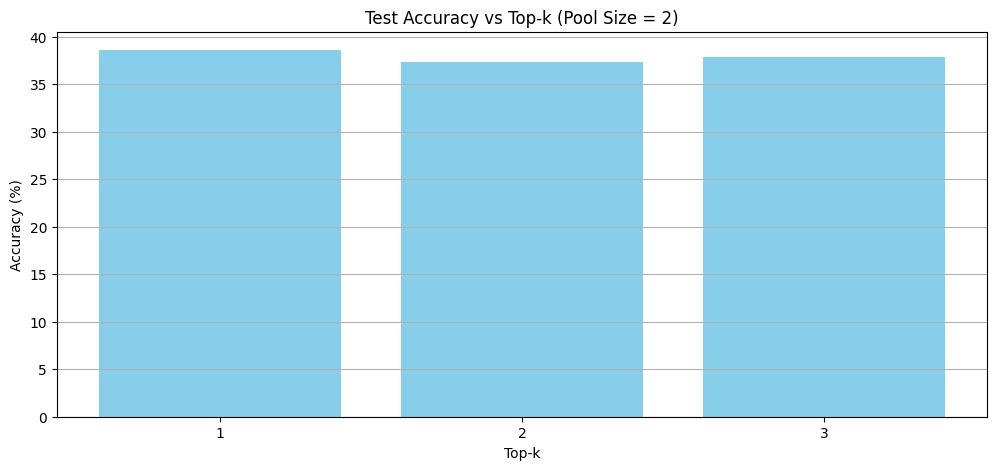

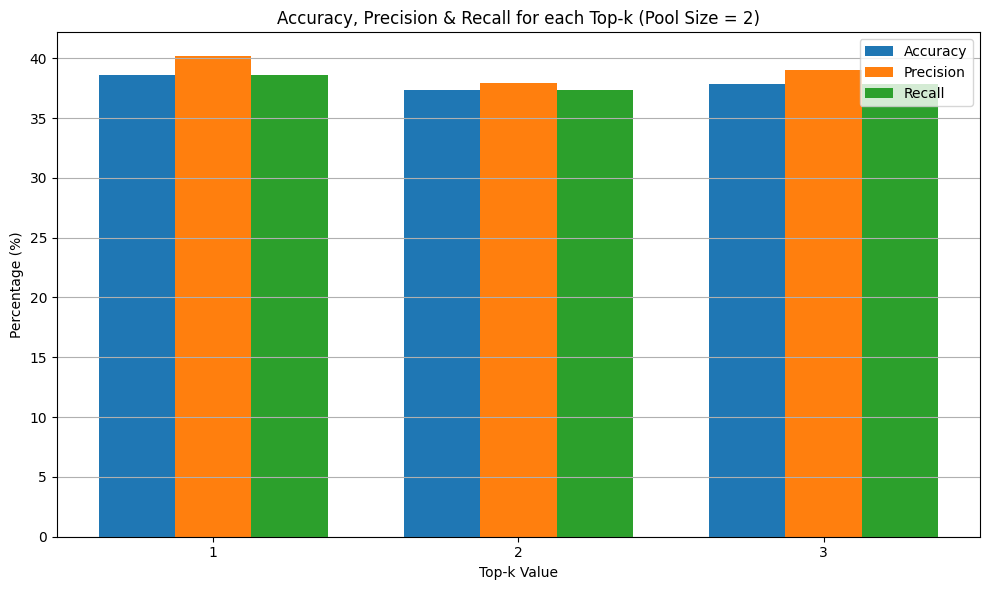

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom AvgTopK Pooling Layer
class AvgTopKPooling2D(nn.Module):
    def __init__(self, k, pool_size=2):
        super().__init__()
        self.k = k
        self.pool_size = pool_size

    def forward(self, x):
        unfolded = F.unfold(x, kernel_size=self.pool_size, stride=self.pool_size)
        B, C_k2, L = unfolded.shape
        C = C_k2 // (self.pool_size ** 2)
        patches = unfolded.view(B, C, self.pool_size ** 2, L)
        topk = torch.topk(patches, self.k, dim=2).values.mean(dim=2)
        output_size = int(x.size(2) / self.pool_size)
        return topk.view(B, C, output_size, output_size)

# CNN Model using AvgTopK
class CNNAvgTopK(nn.Module):
    def __init__(self, k, pool_size=2, num_classes=100):
        super().__init__()
        self.pool1 = AvgTopKPooling2D(k, pool_size)
        self.pool2 = AvgTopKPooling2D(k, pool_size)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        final_size = 32 // (pool_size * 2)
        self.fc1 = nn.Linear(128 * final_size * final_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

# Training and Evaluation
results = []

for k in [1, 2, 3]:
    print(f"\n=== Training with k={k}, pool_size=2 ===")
    model = CNNAvgTopK(k=k, pool_size=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(20):  # Adjust epochs as needed
        model.train()
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.4f}")

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_preds, average='macro') * 100
    recall = recall_score(all_labels, all_preds, average='macro') * 100

    print(f"Test Accuracy (k={k}): {accuracy:.2f}%")
    print(classification_report(all_labels, all_preds))

    results.append({
        'k': k,
        'pool_size': 2,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    })

# Convert to DataFrame
df = pd.DataFrame(results)
print("\n=== Summary Table ===")
print(df)

# Bar Plot: Accuracy vs k
plt.figure(figsize=(12, 5))
plt.bar(df['k'], df['accuracy'], color='skyblue')
plt.title('Test Accuracy vs Top-k (Pool Size = 2)')
plt.xlabel('Top-k')
plt.ylabel('Accuracy (%)')
plt.xticks(df['k'])
plt.grid(axis='y')
plt.show()

# Grouped Bar Plot: Accuracy, Precision, Recall
x = np.arange(len(df['k']))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, df['accuracy'], width=width, label='Accuracy')
plt.bar(x, df['precision'], width=width, label='Precision')
plt.bar(x + width, df['recall'], width=width, label='Recall')

plt.xlabel('Top-k Value')
plt.ylabel('Percentage (%)')
plt.title('Accuracy, Precision & Recall for each Top-k (Pool Size = 2)')
plt.xticks(x, df['k'])
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Files already downloaded and verified
Files already downloaded and verified

=== Training with k=1, pool_size=3 ===
Epoch 1, Loss: 3.7591
Epoch 2, Loss: 2.9814
Epoch 3, Loss: 2.5932
Epoch 4, Loss: 2.3265
Epoch 5, Loss: 2.1280
Epoch 6, Loss: 1.9621
Epoch 7, Loss: 1.8204
Epoch 8, Loss: 1.6965
Epoch 9, Loss: 1.5933
Epoch 10, Loss: 1.4892
Epoch 11, Loss: 1.3890
Epoch 12, Loss: 1.2982
Epoch 13, Loss: 1.2203
Epoch 14, Loss: 1.1398
Epoch 15, Loss: 1.0661
Test Accuracy (k=1): 43.55%
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       100
           1       0.55      0.64      0.59       100
           2       0.34      0.38      0.36       100
           3       0.25      0.40      0.31       100
           4       0.18      0.24      0.20       100
           5       0.48      0.30      0.37       100
           6       0.49      0.46      0.48       100
           7       0.41      0.60      0.49       100
           8       0.56      0.53

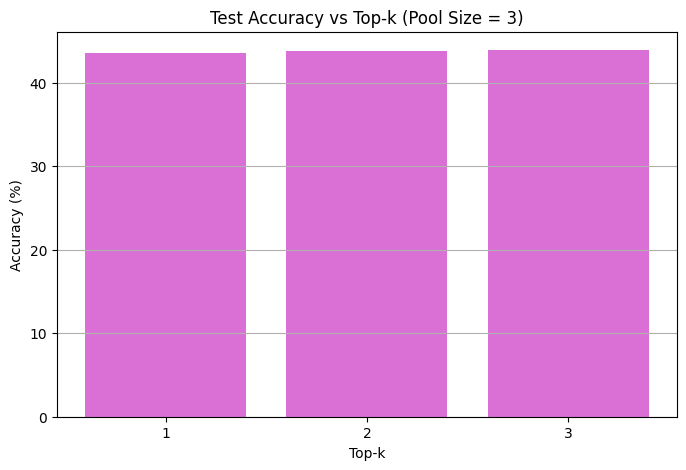

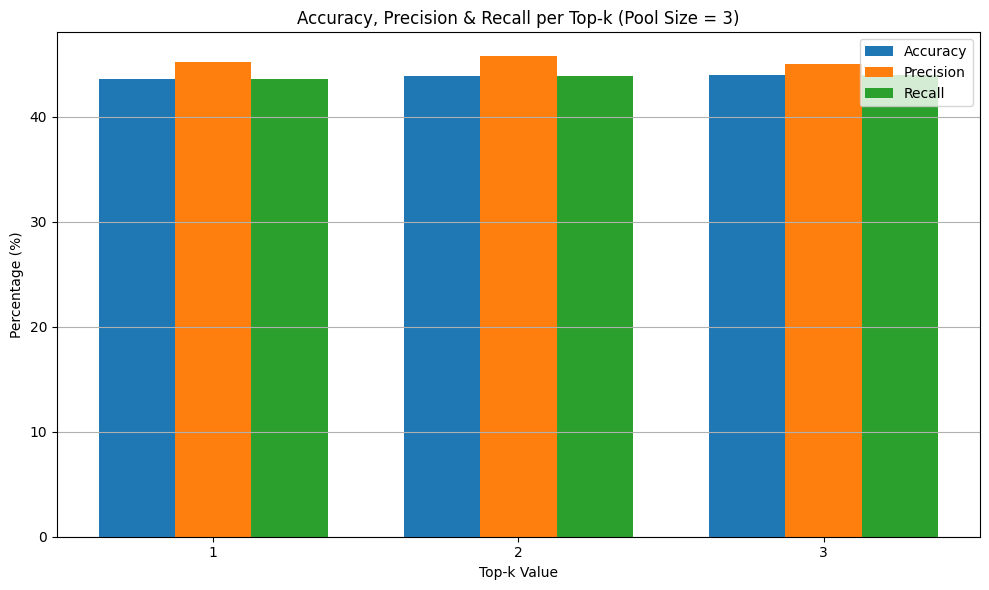

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom AvgTopK Pooling Layer
class AvgTopKPooling2D(nn.Module):
    def __init__(self, k, pool_size=3):
        super().__init__()
        self.k = k
        self.pool_size = pool_size

    def forward(self, x):
        unfolded = F.unfold(x, kernel_size=self.pool_size, stride=self.pool_size)
        B, C_k2, L = unfolded.shape
        C = C_k2 // (self.pool_size ** 2)
        patches = unfolded.view(B, C, self.pool_size ** 2, L)
        topk = torch.topk(patches, self.k, dim=2).values.mean(dim=2)
        output_size = x.size(2) // self.pool_size
        return topk.view(B, C, output_size, output_size)

# CNN Model with AvgTopK
class CNNAvgTopK(nn.Module):
    def __init__(self, k, pool_size=3, num_classes=100, input_size=32):
        super().__init__()
        self.pool1 = AvgTopKPooling2D(k, pool_size)
        self.pool2 = AvgTopKPooling2D(k, pool_size)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Dynamically compute final feature map size
        final_size = input_size
        final_size = final_size // pool_size  # after pool1
        final_size = final_size // pool_size  # after pool2

        self.fc1 = nn.Linear(128 * final_size * final_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# CIFAR-100 Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

# Train + Evaluate
results = []

for k in [1, 2, 3]:
    print(f"\n=== Training with k={k}, pool_size=3 ===")
    model = CNNAvgTopK(k=k, pool_size=3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(15):  # Adjust epochs
        model.train()
        total_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(trainloader):.4f}")

    # Evaluate
    model.eval()
    all_preds, all_labels = [], []
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_preds, average='macro') * 100
    recall = recall_score(all_labels, all_preds, average='macro') * 100

    print(f"Test Accuracy (k={k}): {accuracy:.2f}%")
    print(classification_report(all_labels, all_preds))

    results.append({
        'k': k,
        'pool_size': 3,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    })

# Summary Table
df = pd.DataFrame(results)
print("\n=== Summary Table ===")
print(df)

# Plot: k vs Accuracy
plt.figure(figsize=(8, 5))
plt.bar(df['k'], df['accuracy'], color='orchid')
plt.title('Test Accuracy vs Top-k (Pool Size = 3)')
plt.xlabel('Top-k')
plt.ylabel('Accuracy (%)')
plt.xticks(df['k'])
plt.grid(axis='y')
plt.show()

# Grouped Bar Plot: Accuracy, Precision, Recall
x = np.arange(len(df['k']))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, df['accuracy'], width=width, label='Accuracy')
plt.bar(x, df['precision'], width=width, label='Precision')
plt.bar(x + width, df['recall'], width=width, label='Recall')

plt.xlabel('Top-k Value')
plt.ylabel('Percentage (%)')
plt.title('Accuracy, Precision & Recall per Top-k (Pool Size = 3)')
plt.xticks(x, df['k'])
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
